## Import Libraries and Data Set

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import chisquare, ks_2samp, poisson, norm
import math
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train (15).csv')
test = pd.read_csv('test (15).csv')

## EDA

In [3]:
train.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners
0,2826,793,02/04/2005,410,908,2.0,0.0,15,1
1,2827,793,02/04/2005,338,597,3.0,2.0,3,6
2,2828,793,02/04/2005,1364,246,2.0,3.0,13,2
3,2829,793,02/04/2005,1088,1397,1.0,0.0,2,5
4,2830,793,02/04/2005,830,1412,2.0,3.0,3,6


Split train to train and validation around 80:20

In [5]:
train, val = train_test_split(train, test_size = 0.2, random_state = 111)

In [6]:
train

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners
8191,111379,800,26/08/2007,3592,473,1.0,0.0,5,6
14904,185532,813,23/03/2009,1404,771,1.0,3.0,5,1
10846,142750,816,03/05/2008,662,1107,2.0,1.0,3,2
22774,286768,734,08/10/2010,1212,1061,0.0,0.0,7,6
12498,153496,801,17/08/2008,570,1416,2.0,0.0,2,3
...,...,...,...,...,...,...,...,...,...
7443,107634,816,30/06/2007,604,197,2.0,2.0,2,4
4182,73234,793,29/07/2006,691,1049,1.0,4.0,5,3
4820,77255,813,16/09/2006,1404,2603,2.0,0.0,7,0
10196,138013,800,22/03/2008,382,834,0.0,2.0,5,2


In [7]:
train['Total_Corners'] = train['Home_Corners'] + train['Away_Corners']

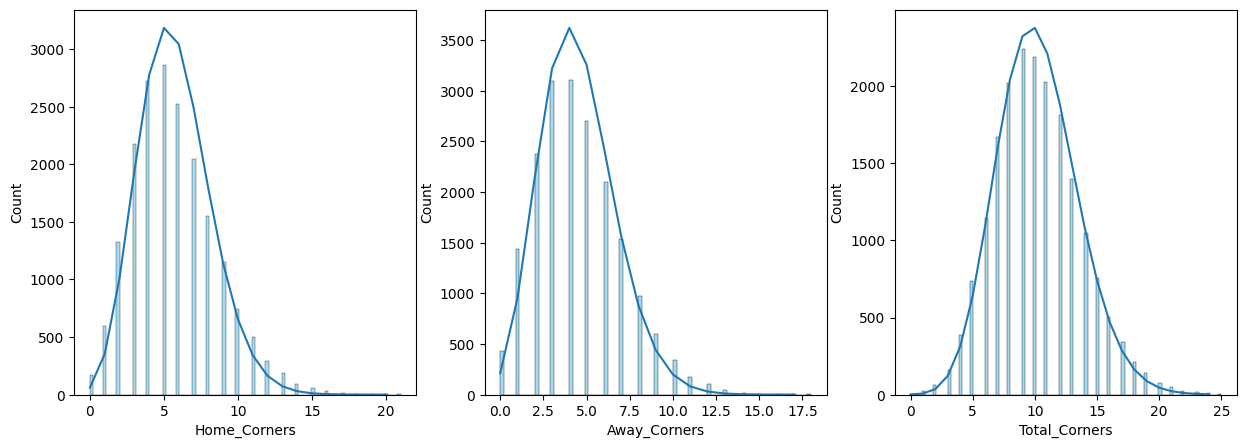

In [8]:
fig, axs = plt.subplots(ncols = 3, figsize = (15, 5))
sns.histplot(data = train['Home_Corners'], color = 'skyblue', ax = axs[0])
x = np.arange(0, train['Home_Corners'].max(), 1)
y = poisson.pmf(x, mu = train['Home_Corners'].mean()) * len(train['Home_Corners'])
axs[0].plot(x, y)

sns.histplot(data = train['Away_Corners'], color = 'skyblue', ax = axs[1])
x = np.arange(0, train['Away_Corners'].max(), 1)
y = poisson.pmf(x, mu = train['Away_Corners'].mean()) * len(train['Away_Corners'])
axs[1].plot(x, y)

sns.histplot(data = train['Total_Corners'], color = 'skyblue', ax = axs[2])
x = np.arange(0, train['Total_Corners'].max(), 1)
y = poisson.pmf(x, mu = train['Total_Corners'].mean()) * len(train['Total_Corners'])
axs[2].plot(x, y)

## Checking Distribution for Corners with KS Test

We use Kolmogorov-Smirnov goodness-of-fit test with the following hypothesis:

H0: the data follow the specified distribution

H1: the data does not follow the specified distribution

### Check whether home corners for each team is well fitted by poisson

In [9]:
p_values = []
for leagueid, teamid in zip(train['LeagueId'], train['HomeTeamId']):
    data = train[(train['LeagueId'] == leagueid) & (train['HomeTeamId'] == teamid)]['Home_Corners']
    poisson_dist = poisson.rvs(size = len(data), mu = data.mean())
    ks_statistic, p_value = ks_2samp(data, poisson_dist)
    p_values.append(p_value)

Average p-value for poisson distribution (home corners)

In [10]:
sum(p_values) / len(p_values)

0.7660973323983239

### Check whether away corners for each team is well fitted by poisson

In [11]:
p_values2 = []
for leagueid, teamid in zip(train['LeagueId'], train['AwayTeamId']):
    data = train[(train['LeagueId'] == leagueid) & (train['AwayTeamId'] == teamid)]['Away_Corners']
    poisson_dist = poisson.rvs(size = len(data), mu = data.mean())
    ks_statistic, p_value = ks_2samp(data, poisson_dist)
    p_values2.append(p_value)

Average p-value for poisson distribution (away corners)

In [12]:
sum(p_values2) / len(p_values2)

0.7843226667265067

Since both averages for p-value is very high, we failed to reject null hypothesis and the data follows poisson distribution.

## Testing the data using validation set

In [13]:
val.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners
23251,294047,813,30/10/2010,988,1404,3.0,0.0,1,5
11636,149392,800,20/06/2008,1279,1351,1.0,2.0,5,3
12009,151652,801,20/07/2008,570,238,3.0,0.0,6,7
2304,20086,729,14/11/2005,601,1185,0.0,2.0,1,6
15718,191969,741,09/05/2009,1424,1117,3.0,1.0,5,3


In [14]:
val['pred_home_corners'] = 0
val['pred_away_corners'] = 0
for i, row in val.iterrows():
    leagueid, homeid, awayid = row['LeagueId'], row['HomeTeamId'], row['AwayTeamId']
    
    # find home corners for the home team
    data = train[(train['LeagueId'] == leagueid) & (train['HomeTeamId'] == homeid)]['Home_Corners']
    val.at[i, 'pred_home_corners'] = poisson.rvs(mu = data.mean(), size = 1)[0]
    
    # find away corners for the away team
    data2 = train[(train['LeagueId'] == leagueid) & (train['AwayTeamId'] == awayid)]['Away_Corners']
    val.at[i, 'pred_away_corners'] = poisson.rvs(mu = data2.mean(), size = 1)[0]

In [15]:
val['total_corners'] = val['Home_Corners'] + val['Away_Corners']
val['pred_total_corners'] = val['pred_home_corners'] + val['pred_away_corners']

In [16]:
val

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,pred_home_corners,pred_away_corners,total_corners,pred_total_corners
23251,294047,813,30/10/2010,988,1404,3.0,0.0,1,5,7,9,6,16
11636,149392,800,20/06/2008,1279,1351,1.0,2.0,5,3,8,2,8,10
12009,151652,801,20/07/2008,570,238,3.0,0.0,6,7,11,4,13,15
2304,20086,729,14/11/2005,601,1185,0.0,2.0,1,6,8,5,7,13
15718,191969,741,09/05/2009,1424,1117,3.0,1.0,5,3,9,9,8,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21049,263077,801,21/06/2010,771,489,0.0,2.0,5,3,12,5,8,17
4110,72871,793,22/07/2006,548,1090,1.0,1.0,7,4,8,4,11,12
18971,223069,800,06/12/2009,1135,369,1.0,2.0,0,3,3,4,3,7
15526,190348,800,02/05/2009,369,3592,4.0,0.0,6,4,7,6,10,13


In [17]:
val['error'] = abs(val['total_corners'] - val['pred_total_corners'])

In [18]:
val['error'].describe()

count    4766.000000
mean        3.706043
std         2.919312
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        19.000000
Name: error, dtype: float64

## Testing

In [19]:
test.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Unnamed: 8,P(Under),P(At),P(Over),Bet (U/O),Stake
0,1,741,01/04/2011,342,694,9.5,1.790,1.80,NaN,NaN,NaN,NaN,NaN,NaN
1,2,741,01/04/2011,1424,270,11.5,1.920,2.00,NaN,NaN,NaN,NaN,NaN,NaN
2,3,729,01/04/2011,691,1137,10.5,1.970,1.87,NaN,NaN,NaN,NaN,NaN,NaN
3,4,729,01/04/2011,787,808,11.0,2.075,1.77,NaN,NaN,NaN,NaN,NaN,NaN
4,5,741,01/04/2011,784,1117,12.0,2.020,1.86,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
test = test.drop(columns=['Unnamed: 8'])

In [21]:
test.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,P(Under),P(At),P(Over),Bet (U/O),Stake
0,1,741,01/04/2011,342,694,9.5,1.790,1.80,NaN,NaN,NaN,NaN,NaN
1,2,741,01/04/2011,1424,270,11.5,1.920,2.00,NaN,NaN,NaN,NaN,NaN
2,3,729,01/04/2011,691,1137,10.5,1.970,1.87,NaN,NaN,NaN,NaN,NaN
3,4,729,01/04/2011,787,808,11.0,2.075,1.77,NaN,NaN,NaN,NaN,NaN
4,5,741,01/04/2011,784,1117,12.0,2.020,1.86,NaN,NaN,NaN,NaN,NaN


In [22]:
for i, row in test.iterrows():
    leagueid, homeid, awayid, line = row['LeagueId'], row['HomeTeamId'], row['AwayTeamId'], row['Line']
    under, at, over = 0, 0, 0
    # find home corners for the home team
    mu_home = train[(train['LeagueId'] == leagueid) &
                    (train['HomeTeamId'] == homeid)]['Home_Corners'].mean()
    if math.isnan(mu_home):
        mu_home = train[train['HomeTeamId'] == homeid]['Home_Corners'].mean()
    
    # find away corners for the away team
    mu_away = train[(train['LeagueId'] == leagueid) &
                    (train['AwayTeamId'] == awayid)]['Away_Corners'].mean()
    if math.isnan(mu_away):
        mu_away = train[train['AwayTeamId'] == awayid]['Away_Corners'].mean()
    
    if abs(line - math.floor(line)) == 0:
        under = int(line) - 1
        at = int(line)
        over = int(line) + 1
    else:
        under = int(math.floor(line))
        at = -1
        over = int(math.ceil(line))
    
    # Find probability of At
    p = 0
    if at == -1:
        test.at[i, 'P(At)'] = 0
    else:
        for x in range(at + 1):
            p += (poisson.pmf(k = x, mu = mu_home) * poisson.pmf(k = at - x, mu = mu_away))
        test.at[i, 'P(At)'] = p
        
    # Find probability of Under
    p2 = 0
    for y in range(under + 1):
        for z in range(under - y + 1):
            p2 += (poisson.pmf(k = y, mu = mu_home) * poisson.pmf(k = z, mu = mu_away))
    test.at[i, 'P(Under)'] = p2
    
    # Find probability of Over
    test.at[i, 'P(Over)'] = 1 - p - p2

In [23]:
test['EV Under'] = test['Under'] * test['P(Under)']
test['EV Over'] = test['Over'] * test['P(Over)']

In [24]:
test

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,P(Under),P(At),P(Over),Bet (U/O),Stake,EV Under,EV Over
0,1,741,01/04/2011,342,694,9.5,1.790,1.800,0.265385,0.000000,0.734615,NaN,NaN,0.477692,1.314962
1,2,741,01/04/2011,1424,270,11.5,1.920,2.000,0.531832,0.000000,0.468168,NaN,NaN,1.063664,0.898883
2,3,729,01/04/2011,691,1137,10.5,1.970,1.870,0.594537,0.000000,0.405463,NaN,NaN,1.111784,0.798763
3,4,729,01/04/2011,787,808,11.0,2.075,1.770,0.386553,0.117285,0.496161,NaN,NaN,0.684199,1.029535
4,5,741,01/04/2011,784,1117,12.0,2.020,1.860,0.565861,0.110484,0.323655,NaN,NaN,1.052501,0.653783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,337,729,22/05/2011,1211,1118,10.5,1.950,1.961,0.263292,0.000000,0.736708,NaN,NaN,0.516315,1.436581
337,338,795,22/05/2011,1116,876,10.0,1.920,1.909,0.467767,0.125071,0.407161,NaN,NaN,0.892968,0.781750
338,339,801,22/05/2011,1223,771,10.0,2.020,1.840,0.461865,0.125104,0.413031,NaN,NaN,0.849831,0.834323
339,340,801,22/05/2011,238,570,10.5,2.020,1.900,0.344035,0.000000,0.655965,NaN,NaN,0.653667,1.325048


In [25]:
def bet(row):
    if row['EV Under'] > row['EV Over']:
        return 'U'
    else:
        return 'O'
    
def kelly(row):
    if row['Bet (U/O)'] == 'U':
        return max(((row['Under']-1) * row['P(Under)'] - row['P(Over)'])/(row['Under']-1), 0)
    else:
        return max(((row['Over']-1) * row['P(Over)'] - row['P(Under)'])/(row['Over']-1), 0)

test['Bet (U/O)'] = test.apply(lambda x: bet(x), axis = 1)
test['Kelly'] = test.apply(lambda x: kelly(x), axis = 1)

In [26]:
test

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,P(Under),P(At),P(Over),Bet (U/O),Stake,EV Under,EV Over,Kelly
0,1,741,01/04/2011,342,694,9.5,1.790,1.800,0.265385,0.000000,0.734615,O,NaN,0.477692,1.314962,0.398686
1,2,741,01/04/2011,1424,270,11.5,1.920,2.000,0.531832,0.000000,0.468168,U,NaN,1.063664,0.898883,0.063664
2,3,729,01/04/2011,691,1137,10.5,1.970,1.870,0.594537,0.000000,0.405463,U,NaN,1.111784,0.798763,0.128487
3,4,729,01/04/2011,787,808,11.0,2.075,1.770,0.386553,0.117285,0.496161,O,NaN,0.684199,1.029535,0.136577
4,5,741,01/04/2011,784,1117,12.0,2.020,1.860,0.565861,0.110484,0.323655,U,NaN,1.052501,0.653783,0.189518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,337,729,22/05/2011,1211,1118,10.5,1.950,1.961,0.263292,0.000000,0.736708,O,NaN,0.516315,1.436581,0.459559
337,338,795,22/05/2011,1116,876,10.0,1.920,1.909,0.467767,0.125071,0.407161,U,NaN,0.892968,0.781750,0.019845
338,339,801,22/05/2011,1223,771,10.0,2.020,1.840,0.461865,0.125104,0.413031,U,NaN,0.849831,0.834323,0.000000
339,340,801,22/05/2011,238,570,10.5,2.020,1.900,0.344035,0.000000,0.655965,O,NaN,0.653667,1.325048,0.318675


In [27]:
test['Stake'] = test['Kelly']/sum(test['Kelly'])

In [28]:
test

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,P(Under),P(At),P(Over),Bet (U/O),Stake,EV Under,EV Over,Kelly
0,1,741,01/04/2011,342,694,9.5,1.790,1.800,0.265385,0.000000,0.734615,O,0.008097,0.477692,1.314962,0.398686
1,2,741,01/04/2011,1424,270,11.5,1.920,2.000,0.531832,0.000000,0.468168,U,0.001293,1.063664,0.898883,0.063664
2,3,729,01/04/2011,691,1137,10.5,1.970,1.870,0.594537,0.000000,0.405463,U,0.002609,1.111784,0.798763,0.128487
3,4,729,01/04/2011,787,808,11.0,2.075,1.770,0.386553,0.117285,0.496161,O,0.002774,0.684199,1.029535,0.136577
4,5,741,01/04/2011,784,1117,12.0,2.020,1.860,0.565861,0.110484,0.323655,U,0.003849,1.052501,0.653783,0.189518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,337,729,22/05/2011,1211,1118,10.5,1.950,1.961,0.263292,0.000000,0.736708,O,0.009333,0.516315,1.436581,0.459559
337,338,795,22/05/2011,1116,876,10.0,1.920,1.909,0.467767,0.125071,0.407161,U,0.000403,0.892968,0.781750,0.019845
338,339,801,22/05/2011,1223,771,10.0,2.020,1.840,0.461865,0.125104,0.413031,U,0.000000,0.849831,0.834323,0.000000
339,340,801,22/05/2011,238,570,10.5,2.020,1.900,0.344035,0.000000,0.655965,O,0.006472,0.653667,1.325048,0.318675


In [29]:
test.drop(columns=['EV Under', 'EV Over', 'Kelly']).to_csv('test_result.csv')